# Points of interest

This notebook was created to iteratively determine which pixels of the sea ice indicator data product should be used for analysis of some chosen points-of-interest. The code here highlights the pixels selected to represent the points of interest and produces the coordinates in EPSG:3411, which are written to `$BASE_DIR/ancillary/points_of_interest.csv`. This notebook is included in `manuscript_content/` because it is part of the analysis for the manuscript, with the aforementioned CSV containing coordinates that are necessary for running a regression analysis and creating some of the manuscript figures. 

This notebook consists of the following sections:

1. [Setup](#1.-Setup) - setup for the notebook, currently just downloads the GSHHG world shoreline shapefile for use here and in the manuscript figures.
2. [Pixel selection](#2.-Pixel-selection) - initially used to iterataively find sets of pixels that should reasonably represent a particular location, this section now currently provides visual summaries of the pixels that were chosen
3. [Sensitivity analysis](#3.-Sensitivity-analysis) - this section provides an analysis of how the pixel selection affects results of regressions of sea ice indicator dates against time (year)

The cells in each section are meant to be executed sequentially, they are not set up to be run independently.

## 1. Setup

Initialize the paths being used and set up directory structure as needed:

In [1]:
import os
from pathlib import Path


scratch_dir = Path(os.getenv("SCRATCH_DIR") or "/atlas_scratch/kmredilla/seaice_noaa_indicators")
out_dir = Path(os.getenv("OUTPUT_DIR") or "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/")
base_dir = Path(os.getenv("BASE_DIR") or "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/")

# final output indicators
# final dataset starts in 1979
fubu_fp = out_dir.joinpath(f"arctic_seaice_fubu_dates_1979-2019.nc")

# make ancillary dir
anc_dir = base_dir.joinpath("ancillary")
anc_dir.mkdir(parents=True, exist_ok=True)

# create extraction directory
gshhg_dir = anc_dir.joinpath("gshhg-shp-2.3.7")
gshhg_dir.mkdir(exist_ok=True)

# download world shoreline polygons
gshhg_url = "https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/gshhg-shp-2.3.7.zip"
gshhg_zip_fp = scratch_dir.joinpath(gshhg_url.split("/")[-1])

gshhs_fp = anc_dir.joinpath("gshhg-shp-2.3.7/GSHHS_shp/i/GSHHS_i_L1.shp")

# landmask derived from bliss et al indicators dataset
landmask_fp = anc_dir.joinpath("landmask_3411.tif")

# coastline mask derived from NSIDC-0051 dataset
coast_fp = scratch_dir.joinpath("coastlines_mask.tif")

### GSHHG world shoreline

Download and load the GSHHG world shoreline file for use here and in map-based figures of the manuscript content.

To overwrite the world shorline polygon files if they already exists, set `clobber=True` in the cell below, otherwise set `clobber=False`.

In [2]:
clobber=False

Run the download and load / reproject.

In [3]:
import zipfile
import geopandas as gpd
from download_ancillary import run_download 


if not gshhs_fp.exists() or clobber:
    print("Downloading GSHHG world shoreline dataset")
    run_download(gshhg_url, gshhg_zip_fp)
    print(f"GSHHG world shoreline dataset written to {gshhg_zip_fp}")

    # unzip the downloaded shoreline dataset
    print("Extracting the downloaded GSHHG data...")
    with zipfile.ZipFile(gshhg_zip_fp, "r") as zip_ref:
        zip_ref.extractall(gshhg_dir)
    print(f"GSHHG world shoreline download extracted to {gshhg_dir}")
else:
    print(
        "GSHHG world shoreline dataset already present in $BASE_DIR, skipping download.", 
    )
    
print("Reading and reprojecting world shorline dataset", end="...")
world_shore = gpd.read_file(gshhs_fp)
world_shore = world_shore.to_crs(epsg=3411).set_index("id")
print("done")

GSHHG world shoreline dataset already present in $BASE_DIR, skipping download.
Reading and reprojecting world shorline dataset...done


### Land mask

Create a land mask raster (255 where land, 0 (nodata) otherwise) from the Bliss et al. indicators dataset and load.

To overwrite the land mask if it already exists, set `clobber=True` in the cell below, otherwise set `clobber=False`.

In [4]:
clobber=False

Create and load the land mask:

In [5]:
import rasterio as rio
import xarray as xr
import rioxarray


if not landmask_fp.exists() or clobber:
    orac_fp = anc_dir.joinpath("arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")

    with xr.open_dataset(orac_fp) as ds:
        dss = ds["DOA"].sel(time=ds["time"].values[0]).copy()

    # mask anything that is not land
    # follow GDAL convention: 0 is nodata, 255 is valid
    dss.values[dss.values != -4] = 0
    dss.values[dss.values == -4] = 255
    dss.values = dss.values.astype(rio.uint8)
    dss.encoding.update({
        "_FillValue": 0,
        "dtype": rio.uint8,
    })
    dss.rio.write_crs(3411).rio.to_raster(landmask_fp)
    print(f"EPSG 3411 landmask created: {landmask_fp}")

# open seamask as reader
landmask_src = rio.open(landmask_fp)

### Coastline mask

Create a coastline mask raster (255 where coast, 0 (nodata) otherwise) from the NSIDC-0051 dataset and load.

To overwrite the coastline mask if it already exists, set `clobber=True` in the cell below, otherwise set `clobber=False`.

In [6]:
clobber=False

Create and load the coastline mask:

In [7]:
# make a coastline mask in scratch_dir if not present  
if not coast_fp.exists() or clobber:
    with rio.open(base_dir.joinpath("nsidc_0051/prepped/nt_19781026_n07_v1-1_n.tif")) as src:
        arr = src.read(1)
        meta = src.meta.copy()

    arr[arr != 253] = 0
    arr[arr == 253] = 255

    arr = arr.astype(rio.uint8)
    meta.update({
        "nodata": 0,
        "dtype": rio.uint8,
    })

    with rio.open(coast_fp, "w", **meta) as src:
        src.write(arr, 1)
    print(f"Coastlines antimask created: {coast_fp}")
    
coast_src = rio.open(scratch_dir.joinpath("coastlines_mask.tif"))

### Sea Ice Indicators dataset

Load the indicators dataset created using this codebase.

In [8]:
import xarray as xr


fubu = xr.load_dataset(fubu_fp)

## 2. Pixel selection

This section was originally used for interactively selecting the grid cell indices to be associated with each location with the help of visual aids (i.e., determining which indices correspond to the most representative pixels for the locations, considering the land mask / coastlines). It is kept for:

1. demonstrating the final selections of the pixels
2. writing the coordinates of those pixels in the EPSG:3411 grid we are working with 
3. extracting the indicator values for these pixels, and writing to CSV for sharing as tables

#### Locations

We chose 10 points of interest around the arctic and selected a pair of lat/lon coordinates for each:

- Utqiaġvik, 71.2906N, 156.7886W
- Chukchi Sea, 68.3478N, 166.8081W (Using coordinates for Point Hope, AK, for reference)
- St Lawrence Island, 62.9N, 169.6W (Using point on south coast of the island)
- Prudhoe Bay, 70.2N, 148.2W
- Pevek, 69.8N, 170.6E
- Tiksi, 71.7N, 126.9E
- Sabetta, 71.3N, 72.1E
- Mestersvig, 72.2N, 23.9W
- Clyde River, 70.3N, 68.3W
- Churchill, 58.8N, 94.2W

As a side note, the first three locations above - Utqiaġvik, Chukchi Sea, and St Lawrence Island - were originally the only locations selected. We then decided to add 7 more locations to achieve a more panarctic representation.

### Processing

Now, perform the following processing steps for all above locations:
1. supply the location info - coordinates, grid cell pixel offsets, spatial files - to create the polygons outlining selected pixels, and to get their projected coordinates
2. extract FUBU values at those projected coordinates and save, with a histogram visual

Imports and setup for this section:

In [9]:
from poi_functions import plot_poi_pixel_polys, plot_date_histograms

# initialize this dict for storing EPSG:3411 coordinates of POIs
poi_coords = {}

# initialize dict for storing indicator results dataframes
poi_indicators = []

### Original points of interest

The decision to use locations for case studies was made with three locations at first - Utqiaġvik, South Chukchi Sea, and south of St. Lawrence Island.

### Utqiaġvik

Utqiaġvik, 71.2906N, 156.7886W

Utqiaġvik done


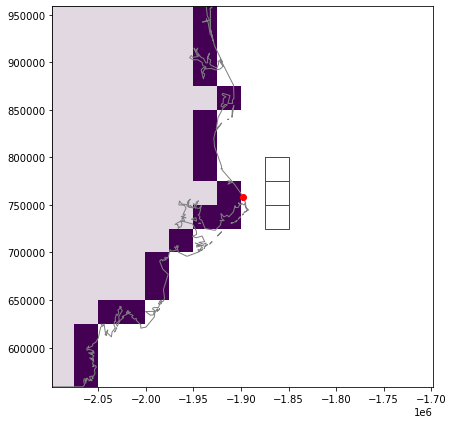

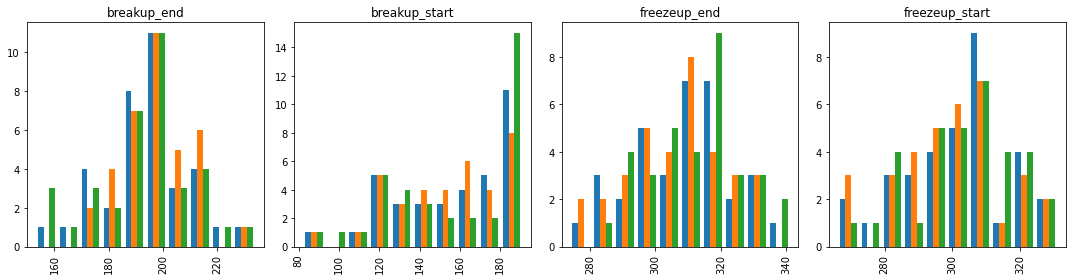

In [10]:
poi_name = "Utqiaġvik"

kwargs = {
    "poi": (71.2906, -156.7886),
    "offsets": [(0, 1), (1, 1), (-1, 1)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### Chukchi Sea

68.3478N, 166.8081W (Using coordinates for Point Hope, AK)

Chukchi Sea done


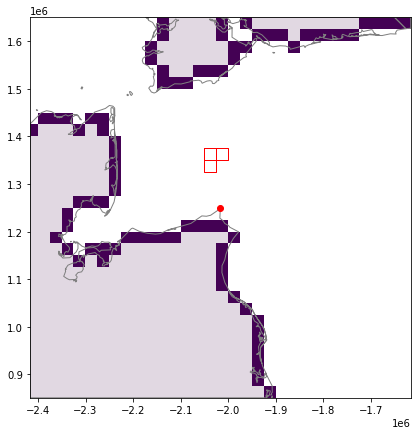

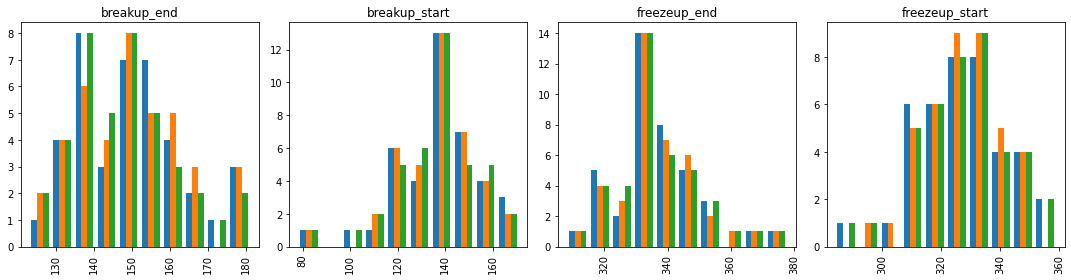

In [11]:
poi_name = "Chukchi Sea"
kwargs = {
    "poi": (68.3478, -166.8081),
    "offsets": [(-4, 0), (-3, -1), (-4, -1)],
    "scale": 4,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### St. Lawrence Island

62.9N, 169.6W (Using point on south coast of the island) 

St. Lawrence Island done


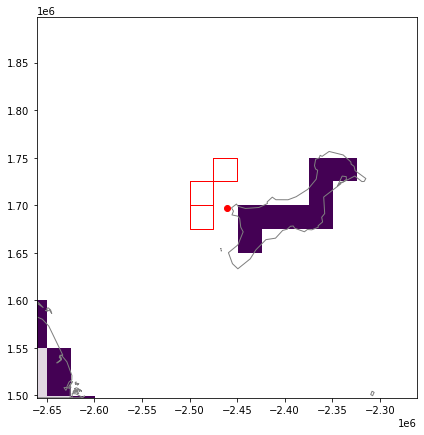

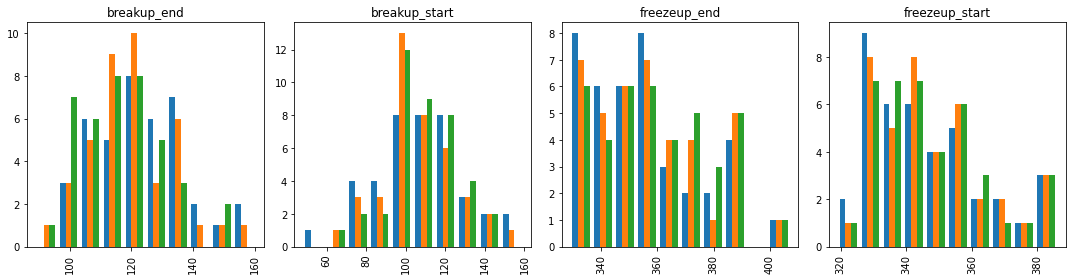

In [12]:
poi_name = "St. Lawrence Island"
kwargs = {
    "poi": (62.9, -169.6),
    "offsets": [(0, -1), (-1, -1), (-2, 0)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

## New points of interest

### Beaufort Sea

Prudhoe Bay, 70.2N, 148.2W

**Note** - it's not really necessary to show the coastline antimask, because it appears to be consistent with the seamask created from the NSIDC-0747 dataset. The point is to demonstrate we've 

Prudhoe Bay done


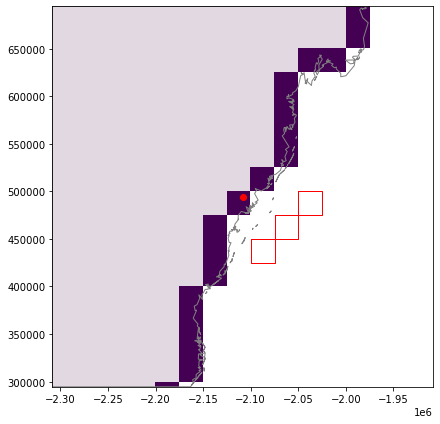

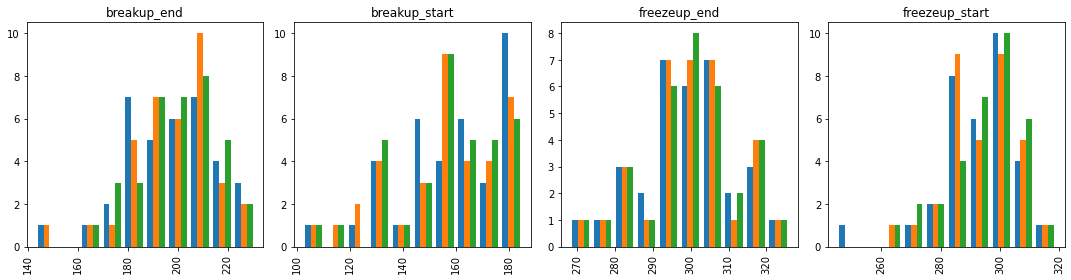

In [13]:
poi_name = "Prudhoe Bay"
kwargs = {
    "poi": (70.2, -148.2),
    "offsets": [(2, 1), (1, 2), (0, 3)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### East Siberian Sea
Pevek, 69.8N, 170.6E

Pevek done


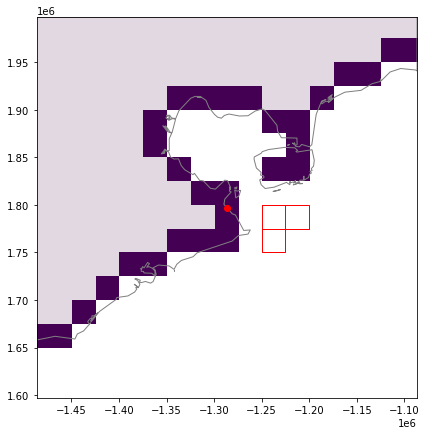

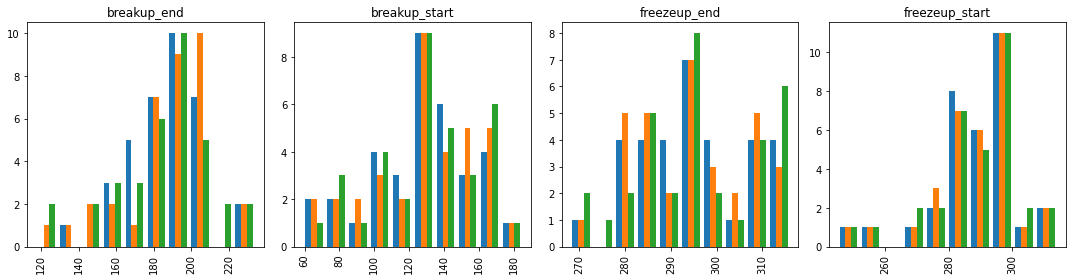

In [14]:
poi_name = "Pevek"
kwargs = {
    "poi": (69.8, 170.6),
    "offsets": [(0, 2), (0, 3), (1, 2)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### Laptev Sea
Tiksi, 71.7N, 126.9E

Tiksi done


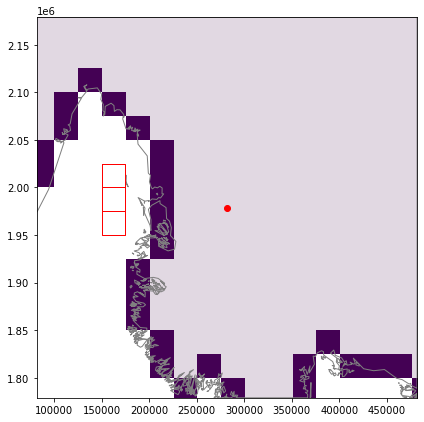

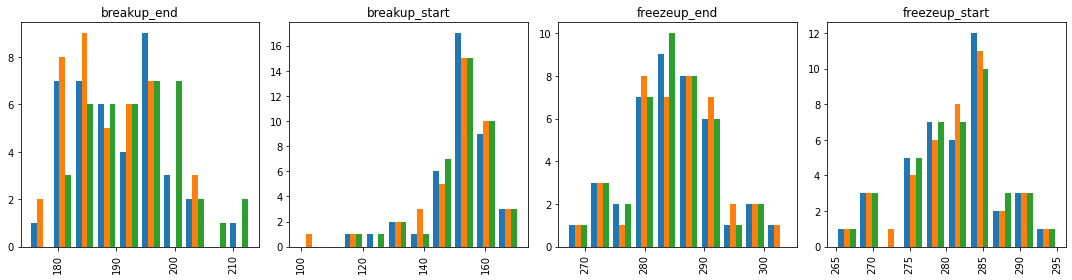

In [15]:
poi_name = "Tiksi"
kwargs = {
    "poi": (71.7, 126.9),
    "offsets": [(0, -5), (1, -5), (-1, -5)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### Kara Sea
Sabetta, 71.3N, 72.1E

Sabetta done


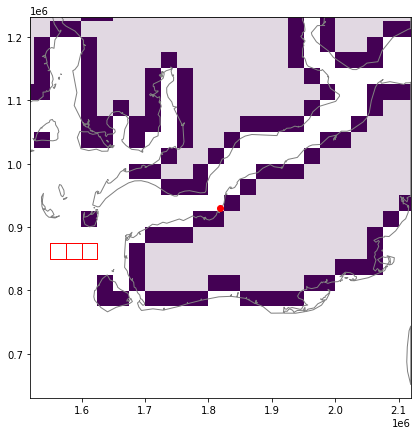

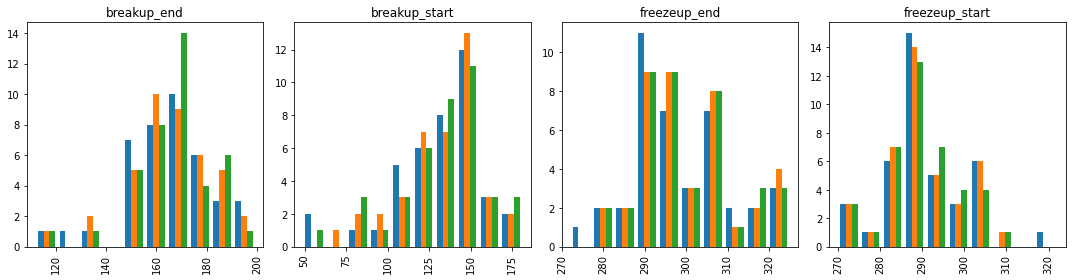

In [16]:
poi_name = "Sabetta"
kwargs = {
    "poi": (71.3, 72.1),
    "offsets": [(3, -10), (3, -9), (3, -8)],
    "scale": 3,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### Greenland Sea
Mestersvig, 72.2N, 23.9W

Mestersvig done


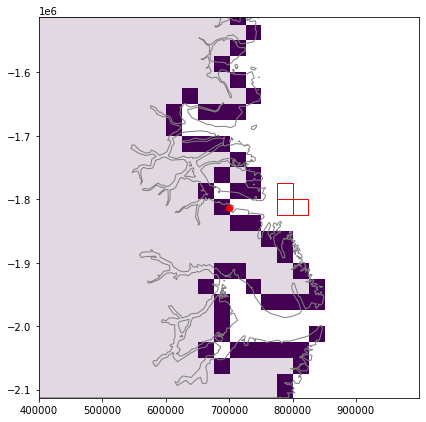

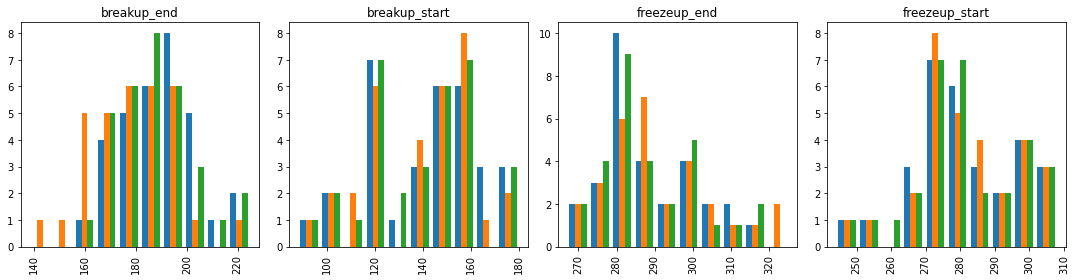

In [17]:
poi_name = "Mestersvig"
kwargs = {
    "poi": (72.2, -23.9),
    "offsets": [(0, 4), (0, 5), (-1, 4)],
    "scale": 3,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### Baffin Bay
Clyde River, 70.3N, 68.3W

Clyde River done


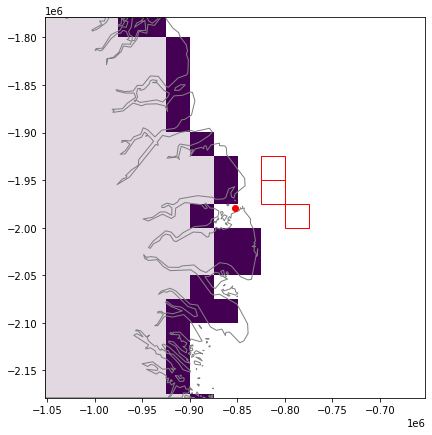

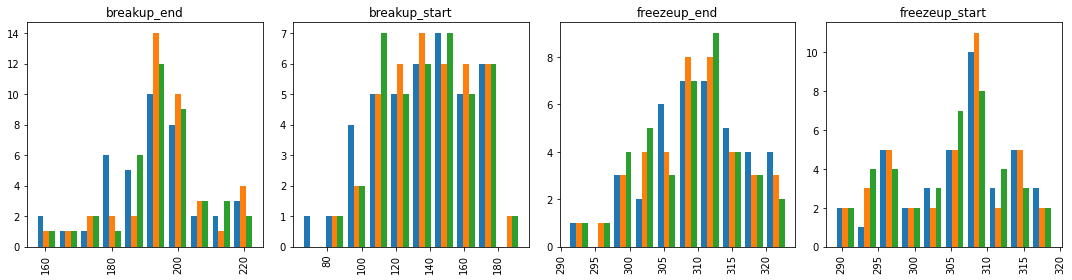

In [18]:
poi_name = "Clyde River"
kwargs = {
    "poi": (70.3, -68.3),
    "offsets": [(0, 3), (-1, 2), (-2, 2)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

### Hudson Bay
Churchill, 58.8N, 94.2W

Churchill done


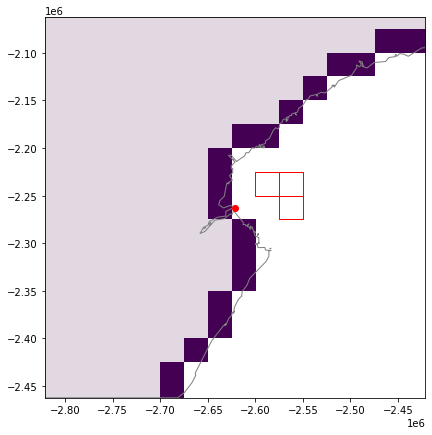

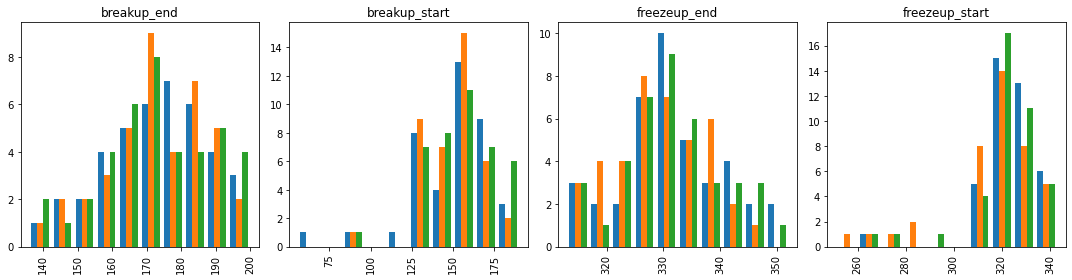

In [19]:
poi_name = "Churchill"
kwargs = {
    "poi": (58.8, -94.2),
    "offsets": [(0, 2), (-1, 1), (-1, 2)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name], poi_name))

print(f"{poi_name} done")

Write the selected coordinates to the `$BASE_DIR/ancillary/points_of_interest.csv`.

In [20]:
import time
import datetime as dt
import pandas as pd


# rearrange dict for friendly DF
new_poi_coords = {
    "location": [],
    "x": [],
    "y": [],
}

for key in poi_coords:
    for point in poi_coords[key]:
        new_poi_coords["location"].append(key)
        new_poi_coords["x"].append(point[0])
        new_poi_coords["y"].append(point[1])

poi_fp = base_dir.joinpath("ancillary/points_of_interest.csv")
pd.DataFrame(new_poi_coords).to_csv(poi_fp, index=False)

print((
    f"Execution completed at {dt.datetime.utcfromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')}, "
    f"coordinates for points-of-interest written to {poi_fp}"),
)

Execution completed at 2022-07-03 01:55:51, coordinates for points-of-interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/points_of_interest.csv


Write the extracted points-of-interest indicators to CSV files: `$BASE_DIR/ancillary/points_of_interest_<indicator>.csv`

In [104]:
temp_fp = base_dir.joinpath("ancillary/poi_{}_dates.csv")
for indicator in np.unique(poi_indicators_df.indicator):
    out_fp = str(temp_fp).format(indicator)
    poi_indicators_df.query(
        f"indicator == '{indicator}'"
    ).pivot(
        index="year", columns="location", values="mean_date"
    ).to_csv(out_fp, index=False)
    print(f"{indicator} dates for points of interest written to {out_fp}")

breakup_end dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_breakup_end_dates.csv
breakup_start dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_breakup_start_dates.csv
freezeup_end dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_freezeup_end_dates.csv
freezeup_start dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_freezeup_start_dates.csv


## 3. Sensitivity analysis

Here, we want to try moving the grid cells for Sabetta and Utqiagvik off-shore by one pixel and compare the average break-up and freeze-up dates with the original.

Plot the original and the offset for each, then compute the summaries of extractions made for the FUBU indicators for each.

### Utqiaġvik

#### Original

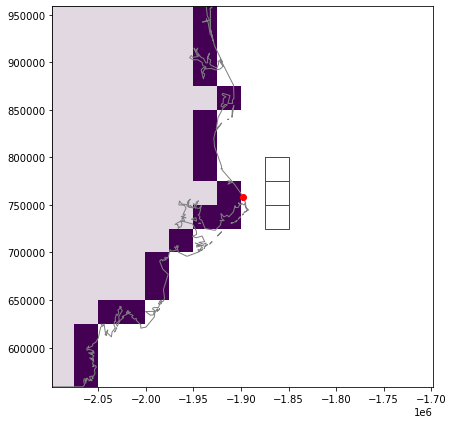

In [39]:
poi_name = "Utqiaġvik"

kwargs = {
    "poi": (71.2906, -156.7886),
    "offsets": [(0, 1), (1, 1), (-1, 1)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

utq_coords = plot_poi_pixel_polys(**kwargs)

#### Offset

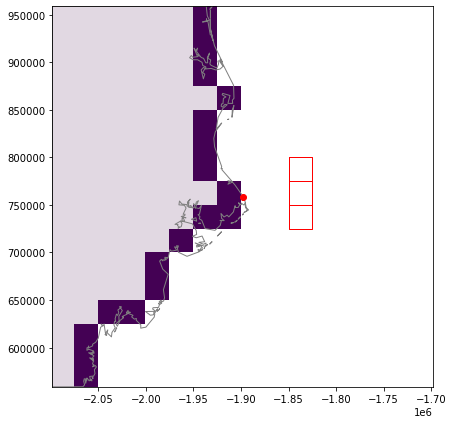

In [40]:
kwargs = {
    "poi": (71.2906, -156.7886),
    "offsets": [(0, 2), (1, 2), (-1, 2)],
    "scale": 2,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

utq_off_coords = plot_poi_pixel_polys(**kwargs)

Coordinates for both sets of pixels:

In [43]:
print("Original:\n", utq_coords)
print("Offset 1 grid cell away from shore:\n", utq_off_coords)

Original:
 [(-1862500.0, 762500.0), (-1862500.0, 737500.0), (-1862500.0, 787500.0)]
Offset 1 grid cell away from shore:
 [(-1837500.0, 762500.0), (-1837500.0, 737500.0), (-1837500.0, 787500.0)]


Define a function to return the mean indicator values by year:

In [60]:
import numpy as np


def summarize_pixels(fubu, indicator, coords):
    arr = np.array([
        fubu[indicator].sel(xc=xc, yc=yc, method="nearest").values
        for (xc, yc) in coords
    ]).astype(float)
    arr[arr == -9999] = np.nan
    
    return arr.mean(axis=0).round()

Print the overall means for both sets of pixels, for all four indicators:

In [61]:
for indicator in ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]:
    original = np.nanmean().round(1)
    offset = np.nanmean().round(1)
    print(f"{indicator}.  Original: {original}, Offset: {offset}")

freezeup_start.  Original: 301.2, Offset: 302.2
freezeup_end.  Original: 308.8, Offset: 307.7
breakup_start.  Original: 156.3, Offset: 153.5
breakup_end.  Original: 194.9, Offset: 197.8


Examine mean differences in indicator values by year:

In [65]:
for indicator in ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]:
    original = summarize_pixels(fubu, indicator, utq_coords)
    offset = summarize_pixels(fubu, indicator, utq_off_coords)
    delta = np.nanmean(np.abs(original - offset)).round(1)
    print(f"{indicator}, mean absolute indicator difference {delta}")

freezeup_start, mean absolute indicator difference 1.3
freezeup_end, mean absolute indicator difference 1.8
breakup_start, mean absolute indicator difference 5.2
breakup_end, mean absolute indicator difference 4.0


Define a function to compute RMSE between vectors of indicator dates

In [70]:
def rmse(predictions, targets):
    return np.sqrt(np.nanmean((predictions - targets) ** 2)).round(1)

Examine RMSE in indicator values

In [72]:
for indicator in ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]:
    original = summarize_pixels(fubu, indicator, utq_coords)
    offset = summarize_pixels(fubu, indicator, utq_off_coords)
    rmse_result = rmse(original, offset)
    print(f"{indicator}, RMSE {rmse_result}")

freezeup_start, RMSE 2.4
freezeup_end, RMSE 3.9
breakup_start, RMSE 9.8
breakup_end, RMSE 6.0


### Sabetta

#### Original

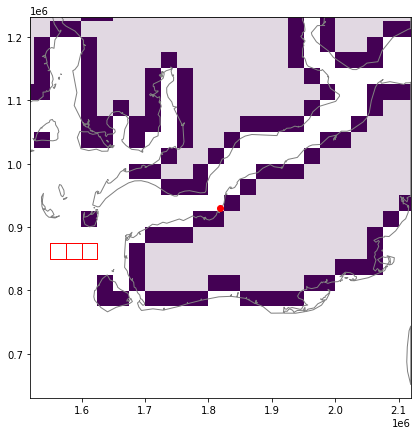

In [73]:
kwargs = {
    "poi": (71.3, 72.1),
    "offsets": [(3, -10), (3, -9), (3, -8)],
    "scale": 3,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

sab_coords = plot_poi_pixel_polys(**kwargs)

#### Offset

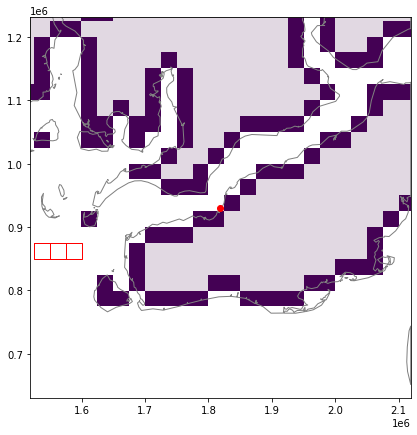

In [74]:
kwargs = {
    "poi": (71.3, 72.1),
    "offsets": [(3, -11), (3, -10), (3, -9)],
    "scale": 3,
    "landmask_src": landmask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

sab_off_coords = plot_poi_pixel_polys(**kwargs)

Coordinates for both sets of pixels:

In [75]:
print("Original:\n", sab_coords)
print("Offset 1 grid cell away from shore:\n", sab_off_coords)

Original:
 [(1562500.0, 862500.0), (1587500.0, 862500.0), (1612500.0, 862500.0)]
Offset 1 grid cell away from shore:
 [(1537500.0, 862500.0), (1562500.0, 862500.0), (1587500.0, 862500.0)]


Print the overall means for both sets of pixels, for all four indicators:

In [76]:
for indicator in ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]:
    original = np.nanmean(summarize_pixels(fubu, indicator, sab_coords)).round(1)
    offset = np.nanmean(summarize_pixels(fubu, indicator, sab_off_coords)).round(1)
    print(f"{indicator}.  Original: {original}, Offset: {offset}")

freezeup_start.  Original: 290.5, Offset: 290.7
freezeup_end.  Original: 299.6, Offset: 298.9
breakup_start.  Original: 132.5, Offset: 132.4
breakup_end.  Original: 166.1, Offset: 165.0


Examine mean differences in indicator values by year:

In [77]:
for indicator in ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]:
    original = summarize_pixels(fubu, indicator, sab_coords)
    offset = summarize_pixels(fubu, indicator, sab_off_coords)
    delta = np.nanmean(np.abs(original - offset)).round(1)
    print(f"{indicator}, mean absolute indicator difference {delta}")

freezeup_start, mean absolute indicator difference 0.6
freezeup_end, mean absolute indicator difference 0.8
breakup_start, mean absolute indicator difference 3.9
breakup_end, mean absolute indicator difference 2.2


Define a function to compute RMSE between vectors of indicator dates

In [70]:
def rmse(predictions, targets):
    return np.sqrt(np.nanmean((predictions - targets) ** 2)).round(1)

Examine RMSE in indicator values

In [78]:
for indicator in ["freezeup_start", "freezeup_end", "breakup_start", "breakup_end"]:
    original = summarize_pixels(fubu, indicator, sab_coords)
    offset = summarize_pixels(fubu, indicator, sab_off_coords)
    rmse_result = rmse(original, offset)
    print(f"{indicator}, RMSE {rmse_result}")

freezeup_start, RMSE 1.0
freezeup_end, RMSE 1.9
breakup_start, RMSE 7.3
breakup_end, RMSE 3.2
